In [1]:
import numpy as np
import pathlib
import random
import torch
import cv2
import optimization_library as optlib

import matplotlib.pyplot as plt
import random
import functools


torch.set_printoptions(precision=3, sci_mode=False)

random.seed(0)
np.random.seed(1)
torch.manual_seed(0)

base_dir = pathlib.Path.cwd()
dlc_model_path = base_dir/"HorseInferenceFiles/DLC_Model_With_Head"
training_data_directory = base_dir / "HorseInferenceFiles"
generated_directory = base_dir/"generated"
urdf_path = base_dir/"horse_based_robot.urdf"
device = optlib.getTorchDevice()
print(f"Training with device: {device}")
robot_data = optlib.RobotData.init_from_urdf_file(urdf_path, device=device)

/Users/aman2/anaconda3/envs/dlc3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-01-11 11:23:26.826601: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/aman2/anaconda3/envs/dlc3/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Training with device: cpu


Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_hip_tran']/actuator[@name='FR_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_thigh_tran']/actuator[@name='FR_thigh_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_calf_tran']/actuator[@name='FR_calf_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_hip_tran']/actuator[@name='FL_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_thigh_tran']/actuator[@name='FL_thigh_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_calf_tran']/actuator[@name='FL_calf_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='RR_hip_tran']/actuator[@name='RR_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='RR_thigh_tran']/actuator[@name='RR_thigh_motor']
Unknown tag "hardwareInterface" 

In [2]:
total_video = optlib.CV2VideoReader((training_data_directory/"trainset/trimmedHorseVideo.mp4"))
total_training_data = optlib.TrainingKeypoints.init_from_video_using_dlc_model(total_video, dlc_model_path)
first_five_frames_data = total_training_data.get_subset(range(5))


2024-01-11 11:23:58.553427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 11:23:58.712512: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


In [3]:
robot_data.print_skeleton()

base
  trunk
    FR_pre_hip
      FR_hip
        FR_thigh
          FR_calf
            FR_foot
    FL_pre_hip
      FL_hip
        FL_thigh
          FL_calf
            FL_foot
    RR_pre_hip
      RR_hip
        RR_thigh
          RR_calf
            RR_foot
    Lower Spine
      Tail
    Upper Spine
      Ears
        Nose
          Jawline
    RL_pre_hip
      RL_hip
        RL_thigh
          RL_calf
            RL_foot


In [4]:
#Basically we define points on the robot in terms of the link that starts at the joint, and the image is defined in terms of the joint at the position
#For example, a knee on the robot is called a calf since the calf starts at the knee joint, and a knee in the image
robot_image_mapping = {
 'trunk' : None,
 'imu_link' : None,
 'FR_hip' : None,
 'FR_thigh': "Shoulder",
 'FR_calf': "Front Right Knee",
 'FR_foot': "Front Right Ankle",
 'FL_hip': None,
 'FL_thigh': "Shoulder",
 'FL_calf': "Front Left Knee",
 'FL_foot': "Front Left Ankle",
 'RR_hip': None,
 'RR_thigh': "Hip",
 'RR_calf': "Back Right Knee",
 'RR_foot': "Back Right Ankle",
 'RL_hip': None,
 'RL_thigh': "Hip",
 'RL_calf': "Back Left Knee",
 'RL_foot' : "Back Left Ankle",
 'Lower Spine': "End of Tail",
 'Tail': "Tip of Tail",
 'Upper Spine': "End of Neck",
 'Ears': "Ears",
 'Nose': "Nose",
 'Jawline': "Jaw",
}

#Removed all None entries
robot_image_mapping = {key:robot_image_mapping[key] for key in robot_image_mapping if robot_image_mapping[key] is not None}

robot_joints_in_order = list(robot_image_mapping.keys())
image_keypoint_orders = [robot_image_mapping[j] for j in robot_joints_in_order]

These are aligned lists, so that we can start putting them in tensors and the alignment will be implicit once they're in tensors.

## Training Loop

In [5]:
trainingFrames = []
draw_on_image = None

In [6]:
class TrainingVariables():
    def __init__(self,*, joint_angles, fx, fy, u0, v0, tx, ty, tz, extrinsicRotationQuaternion):
        self.joint_angles = joint_angles
        self.fx = fx
        self.fy = fy
        self.u0 = u0
        self.v0 = v0
        self.tx = tx
        self.ty = ty
        self.tz = tz
        self.extrinsicRotationQuaternion = extrinsicRotationQuaternion
    @classmethod
    def initialize_from_initials(cls, *,frame_count: int, joint_angles: "(n.joints,)", fx: float, fy: float, u0: float, v0: float, tx: float, ty: float, tz: float, extrinsicRotationQuaternion:"(4) tensor"):
        joint_angles = joint_angles.requires_grad_(False).repeat(frame_count,1).requires_grad_(True)

        differentiableConstantTensor = lambda constant: torch.tensor(float(constant), requires_grad=True)
        
        fx = differentiableConstantTensor(fx)
        fy  = differentiableConstantTensor(fy)
        u0 = differentiableConstantTensor(u0)
        v0 = differentiableConstantTensor(v0)



        tx = torch.ones((frame_count,))*tx
        tx = tx.requires_grad_(True)
        ty = torch.ones((frame_count,))*ty
        ty = ty.requires_grad_(True)
        tz = torch.ones((frame_count,))*tz
        tz = tz.requires_grad_(True)

        #Zero rotation quaternion
        #Good visualization resource: https://quaternions.online
        #JS Script to get as tensor (paste into console): 
        # xPathResults = document.evaluate('//*[@id="container"]/div[2]/table[1]//*[contains(@class, "quaternionInput")]',document,null,XPathResult.ORDERED_NODE_SNAPSHOT_TYPE,null); console.log(`torch.tensor([${Array.from(Array(4).keys()).map(i => xPathResults.snapshotItem(i).value).join(",")}])`);
        extrinsicRotationQuaternion = extrinsicRotationQuaternion.requires_grad_(False).unsqueeze(0) * torch.ones((frame_count,4))
        extrinsicRotationQuaternion = extrinsicRotationQuaternion.requires_grad_(True)
        return cls(joint_angles=joint_angles, fx=fx, fy=fy, u0=u0, v0=v0, tx=tx, ty=ty, tz=tz, extrinsicRotationQuaternion=extrinsicRotationQuaternion)
    def get_as_initials(self):
        joint_angles = self.joint_angles[0].detach().clone()
        tx = self.tx[0]
        ty = self.ty[0]
        tz = self.tz[0]
        extrinsicRotationQuaternion = self.extrinsicRotationQuaternion[0].detach().clone()
        return{
            "joint_angles": joint_angles,
            "fx": float(self.fx),
            "fy": float(self.fy),
            "u0": float(self.u0),
            "v0": float(self.v0),
            "tx": float(tx),
            "ty": float(ty),
            "tz": float(tz),
            "extrinsicRotationQuaternion": extrinsicRotationQuaternion
        }



In [7]:
%matplotlib inline
VERBOSE = True
epoch = 0
def train(*,training_variables, training_data: optlib.TrainingKeypoints,robot_data: optlib.RobotData, epochs:int, epoch_to_visualize: int = 500, training_mode = "All"):
    global draw_on_image
    global trainingFrames
    global epoch
    epoch = epoch + 1
    joint_angles = training_variables.joint_angles
    fx = training_variables.fx
    fy = training_variables.fy
    u0 = training_variables.u0
    v0 = training_variables.v0
    tx = training_variables.tx
    ty = training_variables.ty
    tz = training_variables.tz
    extrinsicRotationQuaternion = training_variables.extrinsicRotationQuaternion
    learnable_robot_model = robot_data.robot_model
    imgCount = training_data.get_frame_count()
    TRAINING_MODES = {
    "All": torch.optim.Adam([fx,fy,u0,v0,tx,ty,tz,extrinsicRotationQuaternion, joint_angles]+ list(learnable_robot_model.parameters()), lr=1e-2),
    "All -Lengths": torch.optim.Adam([fx,fy,u0,v0,tx,ty,tz,extrinsicRotationQuaternion, joint_angles], lr=1e-2),
    "Camera Properties": torch.optim.Adam([fx,fy,u0,v0,tx,ty,tz,extrinsicRotationQuaternion], lr=1e-2),
    }
    optimizer = TRAINING_MODES[training_mode]
    optimizer.zero_grad()

    constantTensor = optlib.constantTensor
    intrinsic = torch.vstack([
        torch.hstack([fx,constantTensor(0), u0]),
        torch.hstack([constantTensor(0),fy, v0]),
        torch.hstack([constantTensor(0),constantTensor(0), constantTensor(1)])
    ])

    formatTensor = torch.tensor([1.0,0.0,0.0])
    xComponent = tx.reshape((-1,*((1,)*(len(formatTensor.shape)))))*(formatTensor.unsqueeze(0))
    formatTensor = torch.tensor([0.0,1.0,0.0])
    yComponent = ty.reshape((-1,*((1,)*(len(formatTensor.shape)))))*(formatTensor.unsqueeze(0))
    formatTensor = torch.tensor([0.0,0.0,1.0])
    zComponent = tz.reshape((-1,*((1,)*(len(formatTensor.shape)))))*(formatTensor.unsqueeze(0))

    extriniscTransformation = xComponent + yComponent + zComponent
    extrinsicRotation = optlib.pytorch3d.transforms.quaternion_to_matrix(extrinsicRotationQuaternion)
    extriniscTransformation = extriniscTransformation.reshape(imgCount,3,1)
    extrinsic = torch.cat((extrinsicRotation, extriniscTransformation),2)
    
    
    #Get Robot Projection
    robotEEPositions = learnable_robot_model.compute_forward_kinematics_all_links(joint_angles)
    #Prune Rotation Information 
    robotEEPositions = {linkName: robotEEPositions[linkName][0] for linkName in robotEEPositions}
    #If Only One Entry Duplicate Data
    for jointName in robotEEPositions:
        if robotEEPositions[jointName].shape[0] != imgCount:
            robotEEPositions[jointName] = robotEEPositions[jointName].repeat(imgCount,1)
    jointPosition = torch.hstack([robotEEPositions[joint].unsqueeze(1) for joint in robot_joints_in_order])
    jointCameraPositions = optlib.calculateCameraProjection(intrinsic, extrinsic, jointPosition)
    pixelLoss = torch.sum(torch.sqrt(torch.sum(torch.pow(jointCameraPositions.reshape(-1,2) - ((training_data.keypoints).reshape(-1,2)), 2),-1)))
           


    loss = 2*pixelLoss + optlib.losses.totalLimbLength(robot_data, relu=True,reluThreshold = 1) + optlib.losses.interframeJointLoss(joint_angles) #+ optlib.losses.out_of_frame_loss(intrinsic,extrinsic, total_video, robotEEPositions, scalar = 100)
    draw_on_image = functools.partial(optlib.drawPredictionOnImage, intrinsic=intrinsic, extrinsic=extrinsic, robotEEPositions=robotEEPositions, training_dataset = training_data, robot_data=robot_data)
    if epoch % 100 == 0 and VERBOSE:
        #Print every n epoch's including the 0th one
        print(f"Epoch {epoch}: Loss ({pixelLoss}), Loss Per Entry ({loss/jointCameraPositions.reshape(-1,2).shape[0]} pixels)")
    trainingFrames.append(draw_on_image(image_index=0))
    n = 500
    if epoch % epoch_to_visualize == 0 and VERBOSE:        
        plt.clf()
        plt.imshow(draw_on_image(image_index=0))
        plt.show()
    loss.backward()
    optimizer.step()

In [8]:
trainingFrames = []
robot_data.make_limb_length_learnable()
init_angles = torch.zeros((1,len(robot_data.get_link_names())))
training_data = first_five_frames_data.reordered_training_set(image_keypoint_orders)
training_variables = TrainingVariables.initialize_from_initials(frame_count = training_data.get_frame_count(), joint_angles=init_angles, fx=1, fy=1, u0=320, v0=160, tx=0, ty=0, tz=1, 
                                                                extrinsicRotationQuaternion=torch.tensor([-1.042,  0.613,  1.721,  2.003])
)
learnable_robot_model = robot_data.robot_model

Epoch 100: Loss (7354.34716796875), Loss Per Entry (163.4440460205078 pixels)
Epoch 200: Loss (7101.20263671875), Loss Per Entry (157.818603515625 pixels)
Epoch 300: Loss (6900.671875), Loss Per Entry (153.36236572265625 pixels)
Epoch 400: Loss (6665.78662109375), Loss Per Entry (148.1427001953125 pixels)
Epoch 500: Loss (6539.60546875), Loss Per Entry (145.3386688232422 pixels)


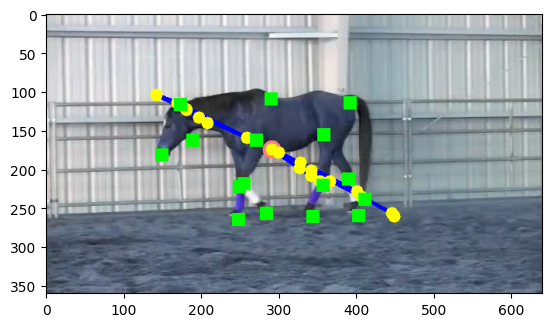

Epoch 600: Loss (6503.91943359375), Loss Per Entry (144.545654296875 pixels)
Epoch 700: Loss (6467.25341796875), Loss Per Entry (143.73085021972656 pixels)
Epoch 800: Loss (6429.3818359375), Loss Per Entry (142.88925170898438 pixels)
Epoch 900: Loss (6392.68115234375), Loss Per Entry (142.0736846923828 pixels)
Epoch 1000: Loss (6356.646484375), Loss Per Entry (141.27291870117188 pixels)


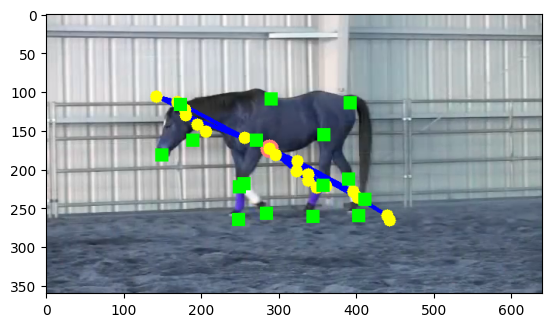

Epoch 1100: Loss (6321.03125), Loss Per Entry (140.48146057128906 pixels)
Epoch 1200: Loss (6283.49169921875), Loss Per Entry (139.64724731445312 pixels)
Epoch 1300: Loss (6247.8671875), Loss Per Entry (138.85560607910156 pixels)
Epoch 1400: Loss (6213.21728515625), Loss Per Entry (138.08560180664062 pixels)
Epoch 1500: Loss (6178.6708984375), Loss Per Entry (137.31790161132812 pixels)


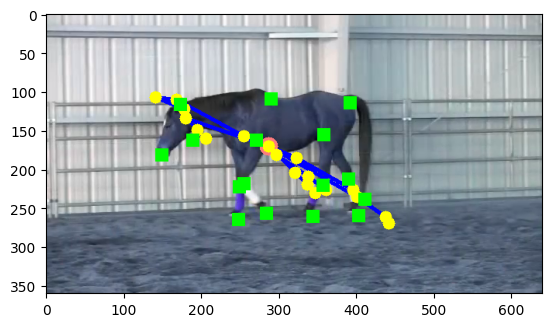

Epoch 1600: Loss (6145.798828125), Loss Per Entry (136.58741760253906 pixels)
Epoch 1700: Loss (6114.9248046875), Loss Per Entry (135.9013214111328 pixels)
Epoch 1800: Loss (6080.6005859375), Loss Per Entry (135.13856506347656 pixels)
Epoch 1900: Loss (6033.00537109375), Loss Per Entry (134.0808868408203 pixels)
Epoch 2000: Loss (5996.4384765625), Loss Per Entry (133.26829528808594 pixels)


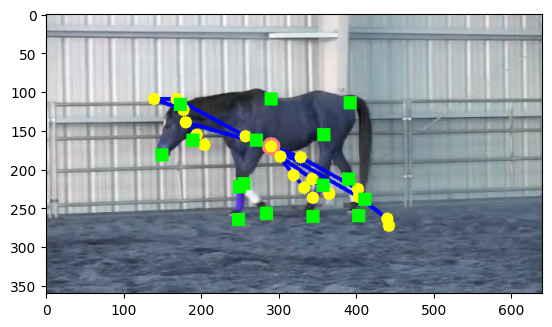

Epoch 2100: Loss (5964.6748046875), Loss Per Entry (132.56243896484375 pixels)
Epoch 2200: Loss (5937.28759765625), Loss Per Entry (131.95382690429688 pixels)
Epoch 2300: Loss (5909.1328125), Loss Per Entry (131.3281707763672 pixels)
Epoch 2400: Loss (5887.0390625), Loss Per Entry (130.83718872070312 pixels)
Epoch 2500: Loss (5861.01806640625), Loss Per Entry (130.2589569091797 pixels)


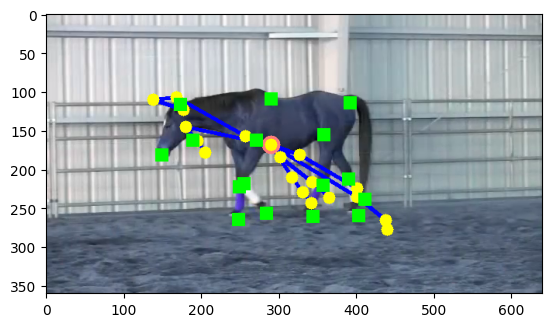

Epoch 2600: Loss (5828.35400390625), Loss Per Entry (129.5330810546875 pixels)
Epoch 2700: Loss (5794.0009765625), Loss Per Entry (128.76968383789062 pixels)
Epoch 2800: Loss (5754.7412109375), Loss Per Entry (127.89724731445312 pixels)
Epoch 2900: Loss (5723.23046875), Loss Per Entry (127.19700622558594 pixels)
Epoch 3000: Loss (5679.02392578125), Loss Per Entry (126.21463775634766 pixels)


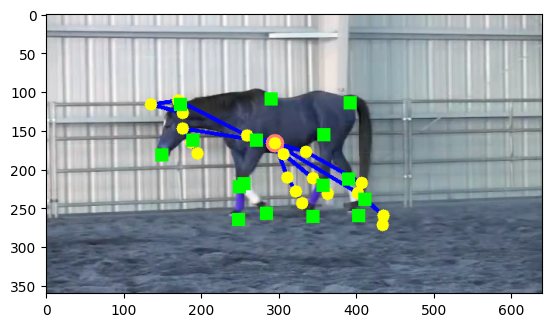

Epoch 3100: Loss (5653.3427734375), Loss Per Entry (125.6439437866211 pixels)
Epoch 3200: Loss (5627.8310546875), Loss Per Entry (125.07701873779297 pixels)
Epoch 3300: Loss (5596.09765625), Loss Per Entry (124.37183380126953 pixels)
Epoch 3400: Loss (5561.50830078125), Loss Per Entry (123.60317993164062 pixels)
Epoch 3500: Loss (5535.98388671875), Loss Per Entry (123.03597259521484 pixels)


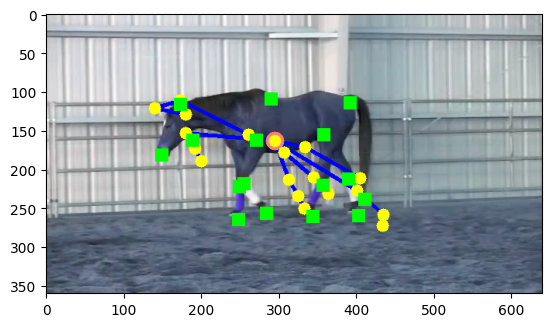

Epoch 3600: Loss (5508.197265625), Loss Per Entry (122.41848754882812 pixels)
Epoch 3700: Loss (5450.57470703125), Loss Per Entry (121.13798522949219 pixels)
Epoch 3800: Loss (5428.4111328125), Loss Per Entry (120.64546203613281 pixels)
Epoch 3900: Loss (5404.90576171875), Loss Per Entry (120.12312316894531 pixels)
Epoch 4000: Loss (5377.7529296875), Loss Per Entry (119.51972961425781 pixels)


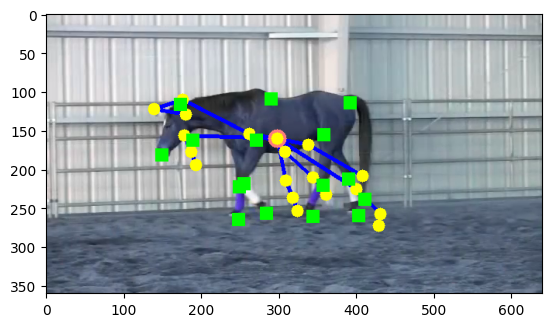

Epoch 4100: Loss (5342.95166015625), Loss Per Entry (118.74636840820312 pixels)
Epoch 4200: Loss (5317.3349609375), Loss Per Entry (118.17710876464844 pixels)
Epoch 4300: Loss (5290.27001953125), Loss Per Entry (117.5756607055664 pixels)
Epoch 4400: Loss (5252.0986328125), Loss Per Entry (116.72740936279297 pixels)
Epoch 4500: Loss (5222.2216796875), Loss Per Entry (116.0634765625 pixels)


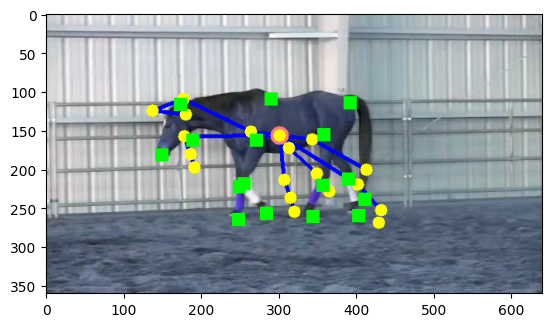

Epoch 4600: Loss (5190.69873046875), Loss Per Entry (115.36296844482422 pixels)
Epoch 4700: Loss (5156.42041015625), Loss Per Entry (114.60122680664062 pixels)
Epoch 4800: Loss (5131.892578125), Loss Per Entry (114.05615997314453 pixels)
Epoch 4900: Loss (5102.7939453125), Loss Per Entry (113.40953063964844 pixels)
Epoch 5000: Loss (5077.7080078125), Loss Per Entry (112.85205841064453 pixels)


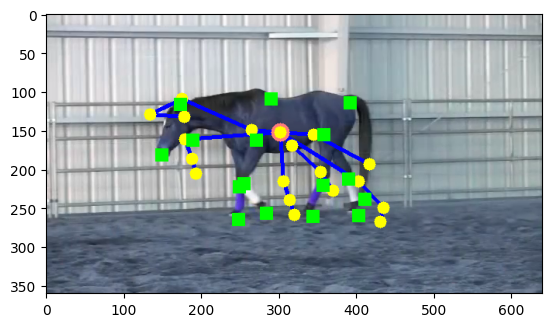

Epoch 5100: Loss (5053.2236328125), Loss Per Entry (112.30796813964844 pixels)
Epoch 5200: Loss (5028.05419921875), Loss Per Entry (111.74864196777344 pixels)
Epoch 5300: Loss (4995.10595703125), Loss Per Entry (111.01646423339844 pixels)
Epoch 5400: Loss (4971.43017578125), Loss Per Entry (110.4903335571289 pixels)
Epoch 5500: Loss (4949.77490234375), Loss Per Entry (110.00910186767578 pixels)


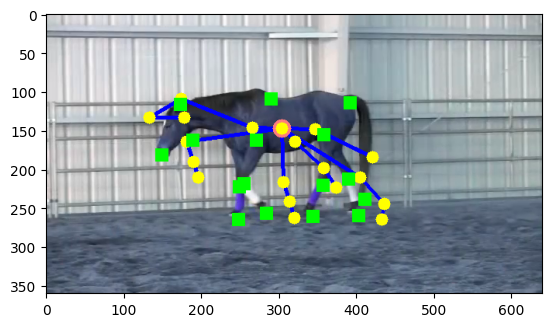

Epoch 5600: Loss (4927.1259765625), Loss Per Entry (109.50579071044922 pixels)
Epoch 5700: Loss (4904.97119140625), Loss Per Entry (109.01346588134766 pixels)
Epoch 5800: Loss (4883.45458984375), Loss Per Entry (108.53531646728516 pixels)
Epoch 5900: Loss (4860.2529296875), Loss Per Entry (108.01972961425781 pixels)
Epoch 6000: Loss (4839.8994140625), Loss Per Entry (107.56742858886719 pixels)


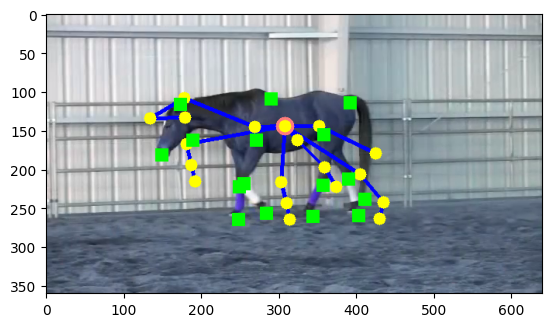

Epoch 6100: Loss (4820.5625), Loss Per Entry (107.1377182006836 pixels)
Epoch 6200: Loss (4799.078125), Loss Per Entry (106.66028594970703 pixels)
Epoch 6300: Loss (4779.2568359375), Loss Per Entry (106.21981048583984 pixels)
Epoch 6400: Loss (4759.73388671875), Loss Per Entry (105.78597259521484 pixels)
Epoch 6500: Loss (4741.88427734375), Loss Per Entry (105.38931274414062 pixels)


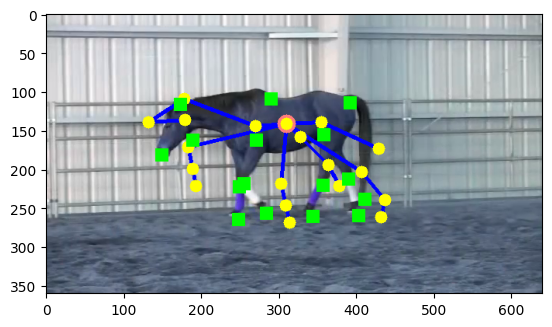

Epoch 6600: Loss (4724.19677734375), Loss Per Entry (104.99625396728516 pixels)
Epoch 6700: Loss (4706.05126953125), Loss Per Entry (104.59302520751953 pixels)
Epoch 6800: Loss (4689.986328125), Loss Per Entry (104.23602294921875 pixels)
Epoch 6900: Loss (4674.107421875), Loss Per Entry (103.88316345214844 pixels)
Epoch 7000: Loss (4659.427734375), Loss Per Entry (103.55694580078125 pixels)


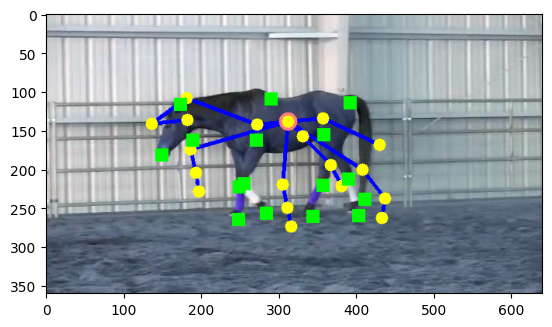

Epoch 7100: Loss (4641.5263671875), Loss Per Entry (103.15913391113281 pixels)
Epoch 7200: Loss (4624.55810546875), Loss Per Entry (102.78206634521484 pixels)
Epoch 7300: Loss (4609.892578125), Loss Per Entry (102.45616149902344 pixels)
Epoch 7400: Loss (4596.7802734375), Loss Per Entry (102.16477966308594 pixels)
Epoch 7500: Loss (4581.7978515625), Loss Per Entry (101.83183288574219 pixels)


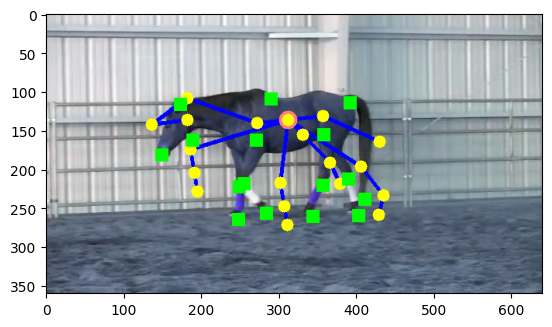

Epoch 7600: Loss (4566.96826171875), Loss Per Entry (101.50228881835938 pixels)
Epoch 7700: Loss (4551.240234375), Loss Per Entry (101.15277862548828 pixels)
Epoch 7800: Loss (4534.6162109375), Loss Per Entry (100.78335571289062 pixels)
Epoch 7900: Loss (4520.791015625), Loss Per Entry (100.47612762451172 pixels)
Epoch 8000: Loss (4503.99072265625), Loss Per Entry (100.10279083251953 pixels)


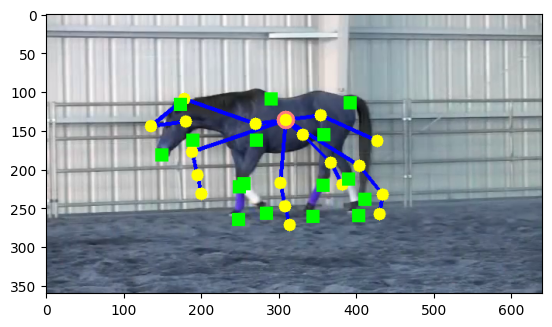

Epoch 8100: Loss (4491.3369140625), Loss Per Entry (99.82159423828125 pixels)
Epoch 8200: Loss (4475.84228515625), Loss Per Entry (99.47726440429688 pixels)
Epoch 8300: Loss (4460.36083984375), Loss Per Entry (99.13323211669922 pixels)
Epoch 8400: Loss (4444.103515625), Loss Per Entry (98.77196502685547 pixels)
Epoch 8500: Loss (4427.259765625), Loss Per Entry (98.39765930175781 pixels)


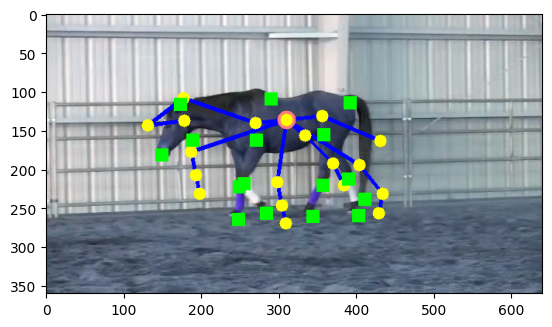

Epoch 8600: Loss (4412.69970703125), Loss Per Entry (98.0740966796875 pixels)
Epoch 8700: Loss (4398.55859375), Loss Per Entry (97.75984954833984 pixels)
Epoch 8800: Loss (4384.2978515625), Loss Per Entry (97.44294738769531 pixels)
Epoch 8900: Loss (4368.685546875), Loss Per Entry (97.09600830078125 pixels)
Epoch 9000: Loss (4351.998046875), Loss Per Entry (96.72517395019531 pixels)


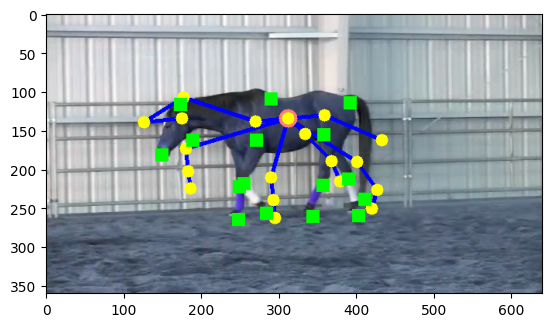

Epoch 9100: Loss (4337.9091796875), Loss Per Entry (96.4120864868164 pixels)
Epoch 9200: Loss (4323.068359375), Loss Per Entry (96.08229064941406 pixels)
Epoch 9300: Loss (4304.8720703125), Loss Per Entry (95.67793273925781 pixels)
Epoch 9400: Loss (4291.81884765625), Loss Per Entry (95.38785552978516 pixels)
Epoch 9500: Loss (4274.47705078125), Loss Per Entry (95.00248718261719 pixels)


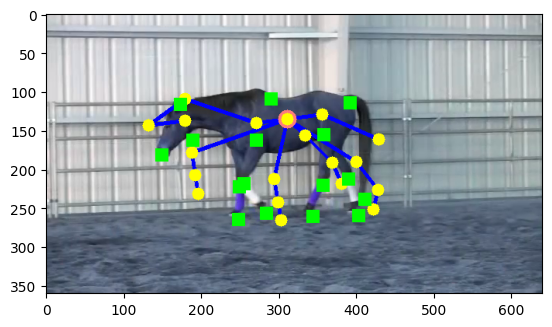

Epoch 9600: Loss (4262.77197265625), Loss Per Entry (94.74237060546875 pixels)
Epoch 9700: Loss (4245.7685546875), Loss Per Entry (94.36451721191406 pixels)
Epoch 9800: Loss (4229.15576171875), Loss Per Entry (93.99534606933594 pixels)
Epoch 9900: Loss (4213.11376953125), Loss Per Entry (93.63885498046875 pixels)
Epoch 10000: Loss (4199.0517578125), Loss Per Entry (93.32637023925781 pixels)


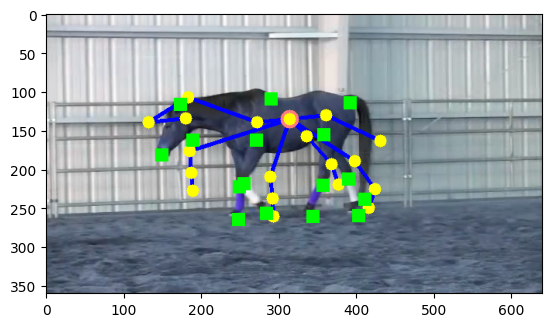

Finished stage 1
Epoch 100: Loss (1178.5201416015625), Loss Per Entry (26.216245651245117 pixels)
Epoch 200: Loss (1149.7913818359375), Loss Per Entry (25.577829360961914 pixels)
Epoch 300: Loss (1077.2884521484375), Loss Per Entry (23.968292236328125 pixels)
Epoch 400: Loss (1046.2939453125), Loss Per Entry (23.27971649169922 pixels)
Epoch 500: Loss (1021.1198120117188), Loss Per Entry (22.71992301940918 pixels)


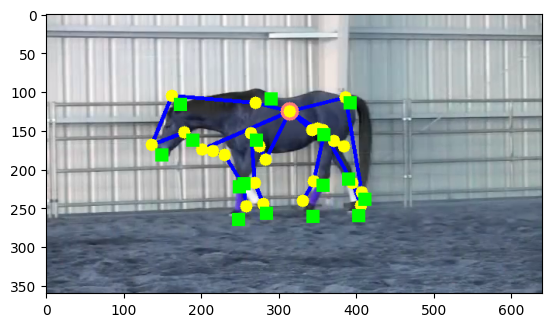

Epoch 600: Loss (1006.193359375), Loss Per Entry (22.387819290161133 pixels)
Epoch 700: Loss (1003.0119018554688), Loss Per Entry (22.31691551208496 pixels)
Epoch 800: Loss (1003.0119018554688), Loss Per Entry (22.31691551208496 pixels)
Epoch 900: Loss (1003.011962890625), Loss Per Entry (22.31691551208496 pixels)
Epoch 1000: Loss (1003.011962890625), Loss Per Entry (22.31691551208496 pixels)


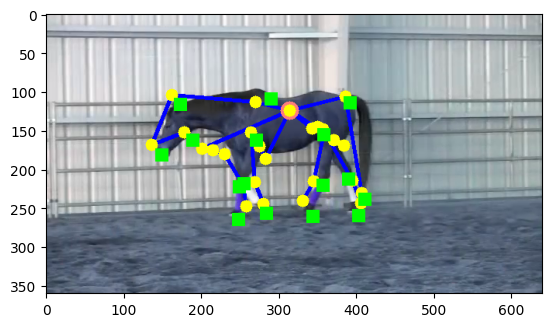

Finished stage 2
Epoch 100: Loss (287704.71875), Loss Per Entry (27.417259216308594 pixels)
Epoch 200: Loss (287706.0625), Loss Per Entry (27.417387008666992 pixels)
Epoch 300: Loss (287706.34375), Loss Per Entry (27.41741371154785 pixels)
Epoch 400: Loss (287706.34375), Loss Per Entry (27.41741371154785 pixels)
Epoch 500: Loss (287706.34375), Loss Per Entry (27.41741371154785 pixels)


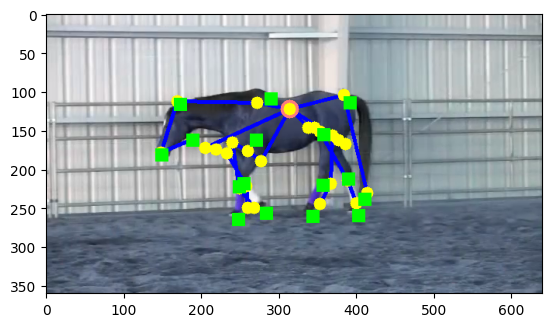

Finished all training


In [9]:
for epoch in range(10000):
    train(epochs = 3000, training_variables=training_variables, training_data = training_data, robot_data = robot_data, training_mode="Camera Properties")
print("Finished stage 1")
training_variables = training_variables.initialize_from_initials(**training_variables.get_as_initials(), frame_count=training_data.get_frame_count())
for epoch in range(1000):
    train(epochs = 3000, training_variables=training_variables, training_data = training_data, robot_data = robot_data)
print("Finished stage 2")
training_data = total_training_data.reordered_training_set(image_keypoint_orders)
training_variables = training_variables.initialize_from_initials(**training_variables.get_as_initials(), frame_count=training_data.get_frame_count())
for epoch in range(500):
    train(epochs = 2000, training_variables=training_variables, training_data = training_data, robot_data = robot_data)
print("Finished all training")

In [32]:
training_variables.joint_angles.shape

torch.Size([1166, 28])

In [39]:
#Index (In joint_angles) to joint_name
index_to_robot_joint = {i:e for i,e in enumerate(robot_joints_in_order)}
joint_angle_by_frame = {joint_name:training_variables.joint_angles.T[index].tolist() for index, joint_name in index_to_robot_joint.items()}
import json
json.dumps(joint_angle_by_frame)

'{"FR_thigh": [0.03999999165534973, 0.03999999165534973, 0.03999999910593033, 0.03999999165534973, 0.040000006556510925, 0.03999999910593033, 0.03999999165534973, 0.03999999165534973, 0.039999984204769135, 0.040000006556510925, 0.03999999910593033, 0.03999999165534973, 0.03999999165534973, 0.03999999165534973, 0.039999984204769135, 0.03999999910593033, 0.03999998793005943, 0.039999984204769135, 0.039999984204769135, 0.03999999165534973, 0.03999999538064003, 0.04000000283122063, 0.03999999165534973, 0.039999984204769135, 0.039999984204769135, 0.03999999910593033, 0.03999999165534973, 0.03999999165534973, 0.040000006556510925, 0.040000006556510925, 0.03999999910593033, 0.03999999165534973, 0.03999999165534973, 0.03999999165534973, 0.03999999165534973, 0.039999984204769135, 0.03999999165534973, 0.040000006556510925, 0.03999999910593033, 0.03999999165534973, 0.039999984204769135, 0.03999999165534973, 0.039999984204769135, 0.03999999165534973, 0.03999999165534973, 0.03999999165534973, 0.039

In [29]:
training_variables.joint_angles.T[5][0], training_variables.joint_angles.T[5][1]

(tensor(0.120, grad_fn=<SelectBackward0>),
 tensor(0.120, grad_fn=<SelectBackward0>))

In [10]:
if not generated_directory.exists():
    generated_directory.mkdir(parents=True)

In [11]:
#Export video of training
vidOut = cv2.VideoWriter(str(generated_directory/'training_video.mp4'),cv2.VideoWriter_fourcc(*'mp4v'), 1, (640,360))
for frame in trainingFrames:
    vidOut.write(frame)
vidOut.release()

In [12]:
#Export video of the frames
vidOut = cv2.VideoWriter(str(generated_directory/'final_video_horse_based.mp4'),cv2.VideoWriter_fourcc(*'mp4v'), 10, (640,360))
for index in range(training_data.get_frame_count()):
    vidOut.write(draw_on_image(image_index=index))
vidOut.release()

In [13]:
exported_robot_path = str(generated_directory/"generatedURDF.urdf")
robot_data.write_to_urdf_file(exported_robot_path)

In [14]:
import numpy as np
from roboticstoolbox.robot.ERobot import ERobot
from math import pi
import pathlib

base_dir = pathlib.Path.cwd()
generated_directory = base_dir/"generated"

class RobotXML(ERobot):

    def __init__(self):

        links, name, urdf_string, urdf_filepath = self.URDF_read(
            exported_robot_path
        )

        super().__init__(
            links,
            name=name,
            urdf_string=urdf_string,
            urdf_filepath=urdf_filepath,
        )

        self.manufacturer = "File Import"


robot = RobotXML()
print(robot)

%matplotlib widget
robot.plot(np.zeros(robot.n), backend="pyplot")

ModuleNotFoundError: No module named 'roboticstoolbox'